In [1]:
import math
from multiprocessing import Value
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
import numpy as np
from skimage.segmentation import find_boundaries
import time

class MaskCollator(object):

    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super(MaskCollator, self).__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes
        self.generator = torch.Generator()  # Initialize a generator
        self.generator.manual_seed(int(time.time()))  # Seed the generator once

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=self.generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h + 1, (1,))
            left = torch.randint(0, self.width - w + 1, (1,))
            max_top = self.height - h
            max_left = self.width - w
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
                    logger.warning(f'Mask generator says: "Valid mask not found, decreasing acceptable-regions [{tries}]"')
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        B = len(batch)

        collated_batch = torch.utils.data.default_collate(batch)

        # seed = self.step()
        # g = torch.Generator()
        # g.manual_seed(seed)
        p_size = self._sample_block_size(
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            
            try:
                if self.allow_overlap:
                    acceptable_regions = None
            except Exception as e:
                logger.warning(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_batch, collated_masks_enc, collated_masks_pred

def load_images(batch_size=4):
    # Transform to normalize the data
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    
    # Load CIFAR10 images
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    # Fetch one batch of images
    dataiter = iter(trainloader)
    images, _ = next(dataiter)
    return tuple(images)

def upscale_mask(mask, patch_size):
    upscaled_mask = mask.repeat_interleave(patch_size, dim=0)
    upscaled_mask = upscaled_mask.repeat_interleave(patch_size, dim=1)
    return upscaled_mask

def visualize_masks(images, masks, masks_p, patch_size, alpha_grid, patch_grid=False):
    fig, axs = plt.subplots(nrows=len(images), ncols=3, figsize=(10, len(images) * 4))
    for i, (img, mask_indices, mask_indices_p) in enumerate(zip(images, masks, masks_p)):
        img = img.permute(1, 2, 0).detach().cpu().numpy()  # Change CxHxW to HxWxC for plotting
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')
        axs[i, 0].set_xlim(0, img.shape[0])
        axs[i, 0].set_ylim(img.shape[1], 0)

        if patch_grid:
            for x in range(0, img.shape[0]+1, patch_size):
                axs[i, 0].axvline(x, color='black', linestyle='--', lw=0.2, alpha=alpha_grid)  # Adjust color and line style if needed
            for y in range(0, img.shape[1]+1, patch_size):
                axs[i, 0].axhline(y, color='black', linestyle='--', lw=0.2, alpha=alpha_grid)  # Adjust color and line style if needed
    
            for x in range(0, img.shape[0]+1, patch_size):
                axs[i, 1].axvline(x, color='black', linestyle='--', lw=0.2, alpha=alpha_grid)  # Adjust color and line style if needed
            for y in range(0, img.shape[1]+1, patch_size):
                axs[i, 1].axhline(y, color='black', linestyle='--', lw=0.2, alpha=alpha_grid)  # Adjust color and line style if needed

            for x in range(0, img.shape[0]+1, patch_size):
                axs[i, 2].axvline(x, color='black', linestyle='--', lw=0.2, alpha=alpha_grid)  # Adjust color and line style if needed
            for y in range(0, img.shape[1]+1, patch_size):
                axs[i, 2].axhline(y, color='black', linestyle='--', lw=0.2, alpha=alpha_grid)  # Adjust color and line style if needed
        
        full_mask = torch.zeros(mask_collator.height, mask_collator.width, dtype=torch.float32)
        for idx in mask_indices:
            row = idx // mask_collator.width
            col = idx % mask_collator.width
            full_mask[row, col] = 1
        
        part_masks_p = torch.zeros(mask_indices_p.shape[0], mask_collator.height, mask_collator.width, dtype=torch.float32)
        for j, part_mask in enumerate(mask_indices_p):
            for idx in part_mask:
                row = idx // mask_collator.width
                col = idx % mask_collator.width
                part_masks_p[j, row, col] = 1
        
        # Upscale mask to match image resolution
        full_mask = upscale_mask(full_mask, mask_collator.patch_size)

        part_masks_p = torch.stack([upscale_mask(sub_mask, mask_collator.patch_size) for sub_mask in part_masks_p])
        full_mask_p = torch.any(part_masks_p, dim=0)
        
        # Apply semi-transparent mask
        masked_img = img.copy()
        full_mask = full_mask.detach().cpu().numpy()
        alpha = 0.6  # transparency level
        # color_mask = np.ones_like(img) * [1, 0, 0]  # red mask
        # masked_img[full_mask == 0] = masked_img[full_mask == 0] * (1 - alpha) + color_mask[full_mask == 0] * alpha

        axs[i, 1].imshow(masked_img)
        axs[i, 1].imshow(np.ma.masked_where(full_mask == 1, full_mask), cmap='cool', vmin=-1, alpha=alpha)
        axs[i, 1].set_title('Final context mask')
        axs[i, 1].axis('off')

        masked_img_p = img.copy()
        # masked_img_p[full_mask_p == 0] = masked_img_p[full_mask_p == 0] * (1 - alpha) + color_mask[full_mask_p == 0] * alpha
        full_mask_p = full_mask_p.detach().cpu().numpy()
        axs[i, 2].imshow(masked_img_p)
        axs[i, 2].imshow(np.ma.masked_where(full_mask_p == 0, full_mask_p), cmap='cool', vmin=0, alpha=alpha, interpolation='none')
        all_mask_boundaries = np.zeros(full_mask_p.shape, dtype='bool')
        for k in range(part_masks_p.shape[0]):
            mask_boundaries = find_boundaries(part_masks_p[k].detach().cpu().numpy(), mode='thin')
            all_mask_boundaries |= mask_boundaries
        axs[i, 2].imshow(np.ma.masked_where(all_mask_boundaries==0, all_mask_boundaries), cmap='cool', vmin=1, alpha=alpha, interpolation='none')
        axs[i, 2].set_title('Target masks')
        axs[i, 2].axis('off')
    plt.show()
    return mask_boundaries

### Hyper Parameters

In [2]:
input_size=(224, 224)
patch_size=8
enc_mask_scale=(0.85, 1.0)
pred_mask_scale=(0.12, 0.15)
aspect_ratio=(0.75, 1.5)
nenc=1
npred=4
min_keep=10
height, width = input_size[0] // patch_size, input_size[1] // patch_size
alpha_grid = 0.5

In [3]:
images = load_images(batch_size=4)

mask_collator = MaskCollator(
input_size=input_size,
patch_size=patch_size,
pred_mask_scale=pred_mask_scale,
enc_mask_scale=enc_mask_scale,
aspect_ratio=aspect_ratio,
nenc=nenc,
npred=npred,
allow_overlap=False,
min_keep=min_keep)

Files already downloaded and verified


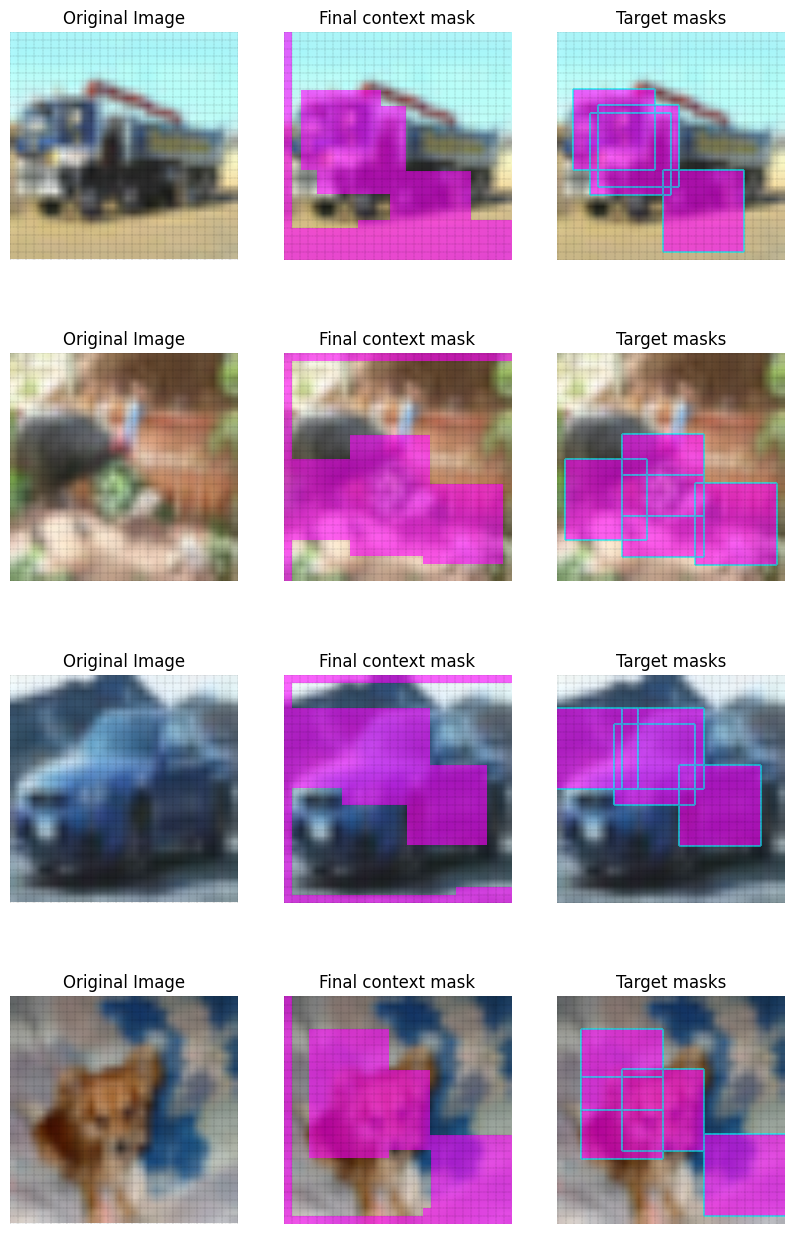

In [4]:
images, masks_enc, masks_p = mask_collator(images)
# collated_masks_enc = mask_collator(images)

stacked_masks_p = torch.stack(masks_p)
reshaped_masks = torch.unbind(stacked_masks_p, dim=1)
# Just use one set of encoder masks for demonstration
mask_indices_p = full_mask_p = visualize_masks(images, masks_enc[0], reshaped_masks, patch_size, alpha_grid, patch_grid=True)